# **Model Handcrafted**

### **Student Identification**

Student Name       | Student Email
-------------------|------------------
Daniel Branco      | r20191230@novaims.unl.pt
Filipe Dias        | r20181050@novaims.unl.pt
Gonçalo Lourenço   | r20191097@novaims.unl.pt
Inês Santos        | r20191184@novaims.unl.pt
Manuel Marreiros   | r20191223@novaims.unl.pt

### **Data Source**

Brain Tumor Classification (MRI) Dataset: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

Drive with data: https://drive.google.com/file/d/1P3hcUss5Kqb28_WQUcTsuTW2VjNTX4pd/view?usp=share_link

### **Notebook Summary**

In this notebook, **Transfer Learning** is performed. This technique consists in taking advantage of pre-trained models used on a problem set and repurposing them to improve generalization on another problem setting.
In this specific case, we will be repurposing 9 models which proved to be very successful in Image Classification problem settings, pre-trained on the [ImageNet](https://www.image-net.org/) dataset. The models are:

* EfficientNetBo
* VGG16
* VGG19
* ResNet50
* ResNet101
* InceptionV3
* InceptionResnetV2
* Dense121
* Xception

On a primary stage, the weights from pre-training were frozen by setting *trainable* = False. On a secondary stage, the weights from pre-training were unfrozen, updating themselves during training. The benfits from this will be explanined further down the notebook.

It it also important to establish that, while these models reveal extreme potential, the objective of this notebook is to experiment, compare and validate the benefits from models contructed based on the prior knowledge provided by these.

### References
1. [Top 4 Pre-Trained Models for Image Classification with Python Code](https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/)
2. [Kaggle - Brain Tumor MRI Classification: TensorFlow CNN](https://www.kaggle.com/code/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn/notebook)
3. [Transfer learning with Keras using DenseNet121](https://bouzouitina-hamdi.medium.com/transfer-learning-with-keras-using-densenet121-fffc6bb0c233)
4. [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
5. [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
6. [Neural Network Embedding and Dense Layers. What’s the difference?](https://medium.com/logivan/neural-network-embedding-and-dense-layers-whats-the-difference-fa177c6d0304#:~:text=The%20two%20main%20advantages%20of,speeding%20up%20the%20training%20time.&text=A%20Dense%20layer%20requires%20the%20input%20to%20be%20strictly%20numerical)


## **Imports**

In [ ]:
pip install keras-tuner tensorflow-addons --quiet

In [ ]:
import os
import time
import math
import random 
import zipfile
import shutil

import numpy as np
import pandas as pd
from skimage.transform import resize

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from tensorflow.keras.initializers import GlorotNormal
import tensorflow_addons as tfa


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.datasets import make_circles
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0f
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import Xception



from warnings import filterwarnings

## **Things needed from previous notebooks**


In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Deep Learning/Projeto/"
main_folder, training_folder, testing_folder = "brain_tumor_data/", "Training/", "Testing/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'brain_tumor_data.zip', 'brain_tumor_data.zip')
    # Extract files
    zip_ = zipfile.ZipFile('brain_tumor_data.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

classes = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]

# Create empty lists to store the number of instances and class names
n_train = []
class_names = []

# Loop through each class in the dataset
for c in classes:
    # Get the number of instances in the training set for the current class
    n_train_c = len(os.listdir(path + main_folder + training_folder + f"/{c}"))
    # Append the number of instances and class name to their respective lists
    n_train.append(n_train_c)
    class_names.append(c)

image_size=(150, 150)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

n_classes = len(classes)
total_samples = np.sum(n_train)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

#PREPROCESSING

class_weights = {}
for i in range(n_classes):
    w = total_samples / (2.0 * n_train[i])
    class_weights[i] = w

print('Class counts:', n_train)
print('Class weights:', class_weights)

input_shape = tuple(batch_x_train.shape)
rescaling = layers.Rescaling(1./255)
batchnormalization = layers.BatchNormalization()

rotation_layer = layers.RandomRotation(factor=0.05)
zoom_layer = layers.RandomZoom(height_factor=0.05, width_factor=0.05)
contrast_layer = layers.RandomContrast(factor=0.10)
brightness_layer = layers.RandomBrightness(factor=0.05)
noise_layer = layers.GaussianNoise(0.05)
flip_layer = layers.RandomFlip(mode='horizontal')
crop_layer = layers.RandomCrop(height=300, width=300)
translation_layer = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)

def augmentation(inputs):
    x = rotation_layer(inputs)
    x = zoom_layer(x)
    x = contrast_layer(x)
    x = brightness_layer(x)
    x = noise_layer(x)
    return x

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 2.957 seconds
Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Using 574 files for validation.
Found 394 files belonging to 4 classes.
Class counts: [395, 826, 822, 827]
Class weights: {0: 3.632911392405063, 1: 1.7372881355932204, 2: 1.745742092457421, 3: 1.735187424425635}


### **Plot Function** 

In [ ]:
def plot_results(history): 
  filterwarnings('ignore')

  # Create DataFrame object
  df_hist = pd.DataFrame.from_dict(history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  # Create plot
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

  # Plot loss curves
  axs[0].plot(df_hist["Epoch"], df_hist["loss"], color='darkred', label='Training Loss')
  axs[0].plot(df_hist["Epoch"], df_hist["val_loss"], color='indianred', label='Validation Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Categorical cross-entropy')
  axs[0].set_title('Loss curves')
  axs[0].legend()
  axs[0].grid(True)

  # Plot accuracy curves
  axs[1].plot(df_hist["Epoch"], df_hist["accuracy"], color='darkblue', label='Training Accuracy')
  axs[1].plot(df_hist["Epoch"], df_hist["val_accuracy"], color='royalblue', label='Validation Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_title('Accuracy curves')
  axs[1].legend()
  axs[1].grid(True)

  # Plot F1-Score curves
  axs[2].plot(df_hist["Epoch"], df_hist["F1-Score"], color='green', label='Training F1-Score')
  axs[2].plot(df_hist["Epoch"], df_hist["val_F1-Score"], color='limegreen', label='Validation F1-Score')
  axs[2].set_xlabel('Epoch')
  axs[2].set_ylabel('F1-Score')
  axs[2].set_title('F1 curves')
  axs[2].legend()
  axs[2].grid(True)

  plt.show()


## **EfficentNetB0**

### **Inference**

In [ ]:
#Base Model 
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# Freeze the weights of base model
effnet.trainable = False

By setting ***trainable* = False**, we are leveraging the pre-trained weights of ImageNet, ensuring that only the weights of the new classification layer are updated during training. This is particularly benefitial when trying to **avoid overfitting, extensive computational effort or when the memory available is limited**.

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In this stage, a model is created by adding 3 layers to the output of the base model.The layers are:
* **Pooling layer**: The GlobalAveragePooling2D layer works by reducing the the dimensions of the base model output and creates a vector with a fixed length for each new input image. This allows the model to become computationally efficient and reduces the risk of overfitting.
* **Dropout layer**: The Dropout layer randomly sets a small portion of the inputs to zero during training to prevent overfitting.
* **Dense layer**: The Dense layer with a softmax activation function produces a probability  distribution over the 4 classes.

In [ ]:
# Freeze the weights for all layers
for layer in model.layers: layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
eff_train = model.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 21s 231ms/step - loss: 3.6056 - accuracy: 0.2896 - F1-Score: 0.2356 - val_loss: 1.4828 - val_accuracy: 0.2596 - val_F1-Score: 0.1672
Epoch 2/12
36/36 [==============================] - 7s 190ms/step - loss: 3.6255 - accuracy: 0.2700 - F1-Score: 0.2212 - val_loss: 1.4828 - val_accuracy: 0.2596 - val_F1-Score: 0.1672
Epoch 3/12
36/36 [==============================] - 4s 102ms/step - loss: 3.5913 - accuracy: 0.2713 - F1-Score: 0.2272 - val_loss: 1.4828 - val_accuracy: 0.2596 - val_F1-Score: 0.1672
Epoch 4/12
36/36 [==============================] - 4s 105ms/step - loss: 3.5668 - accuracy: 0.2840 - F1-Score: 0.2349 - val_loss: 1.4828 - val_accuracy: 0.2596 - val_F1-Score: 0.1672
Epoch 5/12
36/36 [==============================] - 6s 149ms/step - loss: 3.5820 - accuracy: 0.2835 - F1-Score: 0.2287 - val_loss: 1.4828 - val_accuracy: 0.2596 - val_F1-Score: 0.1672
Epoch 6/12
36/36 [==============================] - 4s 103ms/step - loss: 3.647

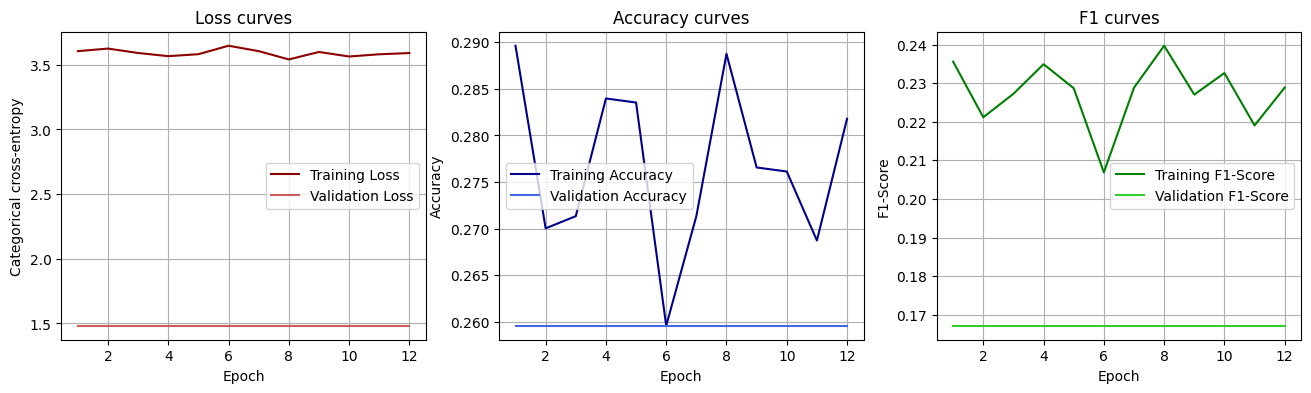

In [ ]:
plot_results(eff_train)

### **Fine-Tunning** 

By setting ***trainable* = True**, we are allowing the weights to be updated during training. This will help achieve higher levels of Accuracy and F1-Score, by leveraging the **pre-existing knowledge and adapting the weights to the new data (Fine-Tunning)**.

In [ ]:
effnet.trainable = True

In [ ]:
model.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
eff_train1 = model.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 61s 372ms/step - loss: 1.0622 - accuracy: 0.7966 - F1-Score: 0.7898 - val_loss: 0.9981 - val_accuracy: 0.7265 - val_F1-Score: 0.7001
Epoch 2/12
36/36 [==============================] - 11s 284ms/step - loss: 0.2914 - accuracy: 0.9486 - F1-Score: 0.9494 - val_loss: 0.3671 - val_accuracy: 0.8972 - val_F1-Score: 0.8984
Epoch 3/12
36/36 [==============================] - 11s 284ms/step - loss: 0.1556 - accuracy: 0.9765 - F1-Score: 0.9758 - val_loss: 0.3901 - val_accuracy: 0.9216 - val_F1-Score: 0.9238
Epoch 4/12
36/36 [==============================] - 11s 282ms/step - loss: 0.1024 - accuracy: 0.9830 - F1-Score: 0.9839 - val_loss: 0.4877 - val_accuracy: 0.8885 - val_F1-Score: 0.8931
Epoch 5/12
36/36 [==============================] - 12s 329ms/step - loss: 0.0906 - accuracy: 0.9826 - F1-Score: 0.9834 - val_loss: 0.3564 - val_accuracy: 0.9355 - val_F1-Score: 0.9368
Epoch 6/12
36/36 [==============================] - 12s 327ms/step - loss: 

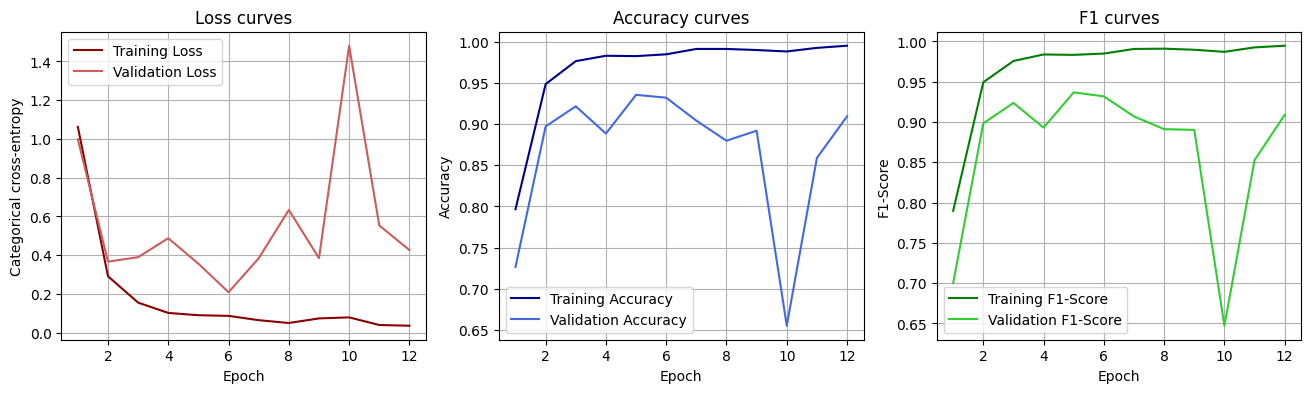

In [ ]:
plot_results(eff_train1)

### **Prediction**

In [ ]:
model.evaluate(ds_test)

7/7 [==============================] - 2s 152ms/step - loss: 1.0613 - accuracy: 0.7843 - F1-Score: 0.7795


[1.0613203048706055, 0.7842639684677124, 0.7795329093933105]

In [ ]:
# Make predictions on the test set
y_pred = model.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 3s 68ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.29      0.18      0.22       100
meningioma_tumor       0.30      0.35      0.32       115
        no_tumor       0.32      0.40      0.36       105
 pituitary_tumor       0.14      0.12      0.13        74

        accuracy                           0.28       394
       macro avg       0.26      0.26      0.26       394
    weighted avg       0.27      0.28      0.27       394



## **VGG16**

### **Inference**

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
vgg16.trainable = False

In [ ]:
model1 = vgg16.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(rate=0.5)(model1)
model1 = tf.keras.layers.Dense(4, activation='softmax')(model1)
model1 = tf.keras.models.Model(inputs=vgg16.input, outputs=model1)

In [ ]:
# Freeze the weights for all layers
for layer in model1.layers: layer.trainable = False

In [ ]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
model1.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
vgg16_train = model1.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 24s 536ms/step - loss: 22.8284 - accuracy: 0.2304 - F1-Score: 0.2297 - val_loss: 7.1634 - val_accuracy: 0.2195 - val_F1-Score: 0.2085
Epoch 2/12
36/36 [==============================] - 7s 179ms/step - loss: 22.9524 - accuracy: 0.2230 - F1-Score: 0.2208 - val_loss: 7.1634 - val_accuracy: 0.2195 - val_F1-Score: 0.2085
Epoch 3/12
36/36 [==============================] - 8s 207ms/step - loss: 22.6225 - accuracy: 0.2234 - F1-Score: 0.2212 - val_loss: 7.1634 - val_accuracy: 0.2195 - val_F1-Score: 0.2085
Epoch 4/12
36/36 [==============================] - 7s 169ms/step - loss: 22.5335 - accuracy: 0.2300 - F1-Score: 0.2271 - val_loss: 7.1634 - val_accuracy: 0.2195 - val_F1-Score: 0.2085
Epoch 5/12
36/36 [==============================] - 7s 179ms/step - loss: 22.0849 - accuracy: 0.2391 - F1-Score: 0.2366 - val_loss: 7.1634 - val_accuracy: 0.2195 - val_F1-Score: 0.2085
Epoch 6/12
36/36 [==============================] - 7s 168ms/step - loss: 

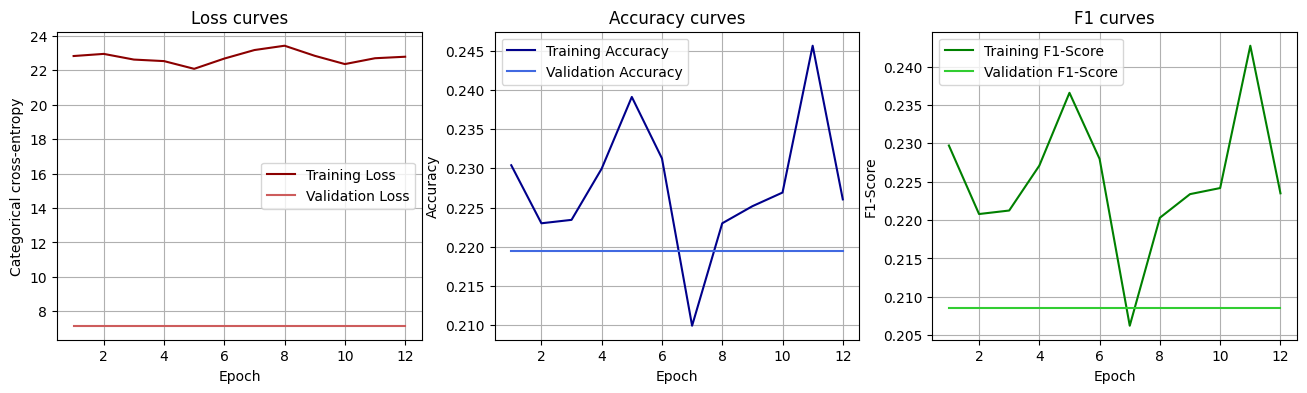

In [ ]:
plot_results(vgg16_train)

### **Training** 

In [ ]:
vgg16.trainable = True

In [ ]:
model1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
vgg16_train1 = model1.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 38s 675ms/step - loss: 4.4565 - accuracy: 0.4037 - F1-Score: 0.3719 - val_loss: 1.0742 - val_accuracy: 0.5174 - val_F1-Score: 0.4589
Epoch 2/12
36/36 [==============================] - 17s 446ms/step - loss: 1.9827 - accuracy: 0.5832 - F1-Score: 0.5316 - val_loss: 0.7936 - val_accuracy: 0.6986 - val_F1-Score: 0.6609
Epoch 3/12
36/36 [==============================] - 17s 446ms/step - loss: 1.4843 - accuracy: 0.7130 - F1-Score: 0.6841 - val_loss: 0.6195 - val_accuracy: 0.7700 - val_F1-Score: 0.7586
Epoch 4/12
36/36 [==============================] - 18s 486ms/step - loss: 1.1724 - accuracy: 0.7661 - F1-Score: 0.7466 - val_loss: 0.5116 - val_accuracy: 0.8153 - val_F1-Score: 0.8119
Epoch 5/12
36/36 [==============================] - 17s 447ms/step - loss: 0.9716 - accuracy: 0.8088 - F1-Score: 0.8003 - val_loss: 0.4294 - val_accuracy: 0.8449 - val_F1-Score: 0.8430
Epoch 6/12
36/36 [==============================] - 17s 448ms/step - loss: 

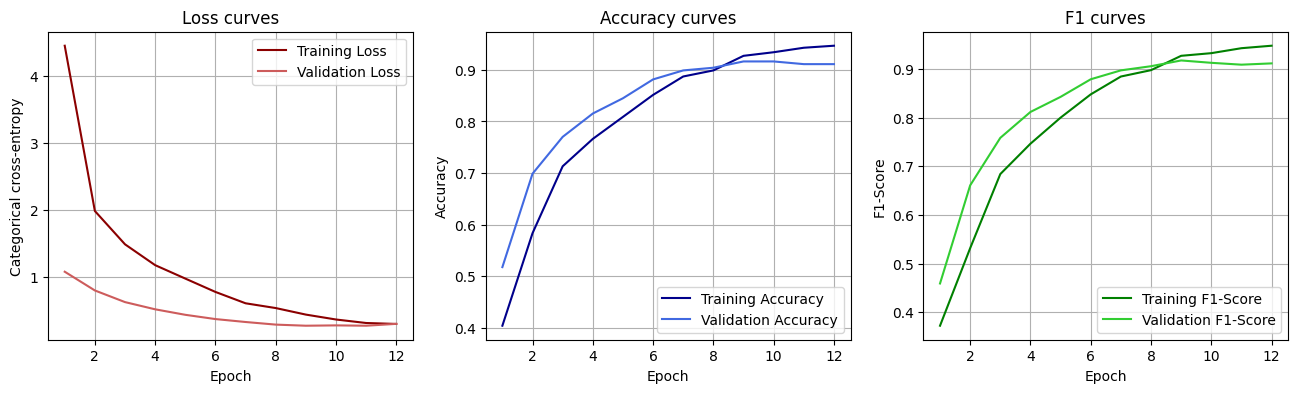

In [ ]:
plot_results(vgg16_train1)

### **Prediction**

In [ ]:
model1.evaluate(ds_test)

7/7 [==============================] - 2s 284ms/step - loss: 2.0941 - accuracy: 0.7081 - F1-Score: 0.6717


[2.0941457748413086, 0.7081218361854553, 0.6717159152030945]

In [ ]:
# Make predictions on the test set
y_pred = model1.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 2s 123ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.23      0.08      0.12       100
meningioma_tumor       0.28      0.37      0.32       115
        no_tumor       0.29      0.43      0.34       105
 pituitary_tumor       0.18      0.12      0.15        74

        accuracy                           0.27       394
       macro avg       0.24      0.25      0.23       394
    weighted avg       0.25      0.27      0.24       394



## **VGG19**

### **Inference**

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
vgg19.trainable = False

In [ ]:
model2 = vgg19.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
model2 = tf.keras.layers.Dense(4,activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=vgg19.input, outputs = model2)

In [ ]:
# Freeze the weights for all layers
for layer in model2.layers: layer.trainable = False

In [ ]:
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [ ]:
model2.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
vgg19_train = model2.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 9s 210ms/step - loss: 20.9984 - accuracy: 0.2779 - F1-Score: 0.2499 - val_loss: 5.2021 - val_accuracy: 0.3118 - val_F1-Score: 0.2420
Epoch 2/12
36/36 [==============================] - 8s 201ms/step - loss: 20.9676 - accuracy: 0.2783 - F1-Score: 0.2440 - val_loss: 5.2021 - val_accuracy: 0.3118 - val_F1-Score: 0.2420
Epoch 3/12
36/36 [==============================] - 8s 207ms/step - loss: 20.4997 - accuracy: 0.2835 - F1-Score: 0.2478 - val_loss: 5.2021 - val_accuracy: 0.3118 - val_F1-Score: 0.2420
Epoch 4/12
36/36 [==============================] - 9s 235ms/step - loss: 20.9772 - accuracy: 0.2787 - F1-Score: 0.2467 - val_loss: 5.2021 - val_accuracy: 0.3118 - val_F1-Score: 0.2420
Epoch 5/12
36/36 [==============================] - 8s 201ms/step - loss: 20.7756 - accuracy: 0.2840 - F1-Score: 0.2489 - val_loss: 5.2021 - val_accuracy: 0.3118 - val_F1-Score: 0.2420
Epoch 6/12
36/36 [==============================] - 8s 199ms/step - loss: 2

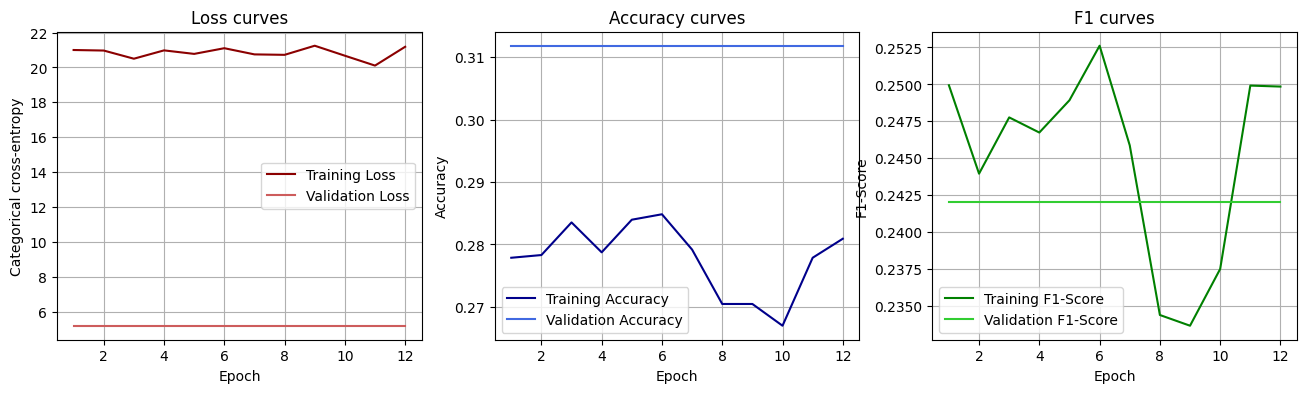

In [ ]:
plot_results(vgg19_train)

### **Training** 

In [ ]:
vgg19.trainable = True

In [ ]:
model2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
vgg19_train1 = model2.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 27s 540ms/step - loss: 4.2275 - accuracy: 0.3994 - F1-Score: 0.3683 - val_loss: 1.0068 - val_accuracy: 0.5470 - val_F1-Score: 0.4749
Epoch 2/12
36/36 [==============================] - 20s 535ms/step - loss: 1.9423 - accuracy: 0.6159 - F1-Score: 0.5778 - val_loss: 0.7166 - val_accuracy: 0.7334 - val_F1-Score: 0.7129
Epoch 3/12
36/36 [==============================] - 21s 580ms/step - loss: 1.3825 - accuracy: 0.7369 - F1-Score: 0.7206 - val_loss: 0.6002 - val_accuracy: 0.7578 - val_F1-Score: 0.7454
Epoch 4/12
36/36 [==============================] - 21s 557ms/step - loss: 1.1021 - accuracy: 0.7861 - F1-Score: 0.7752 - val_loss: 0.4409 - val_accuracy: 0.8380 - val_F1-Score: 0.8348
Epoch 5/12
36/36 [==============================] - 20s 541ms/step - loss: 0.8608 - accuracy: 0.8463 - F1-Score: 0.8412 - val_loss: 0.3618 - val_accuracy: 0.8711 - val_F1-Score: 0.8643
Epoch 6/12
36/36 [==============================] - 20s 547ms/step - loss: 

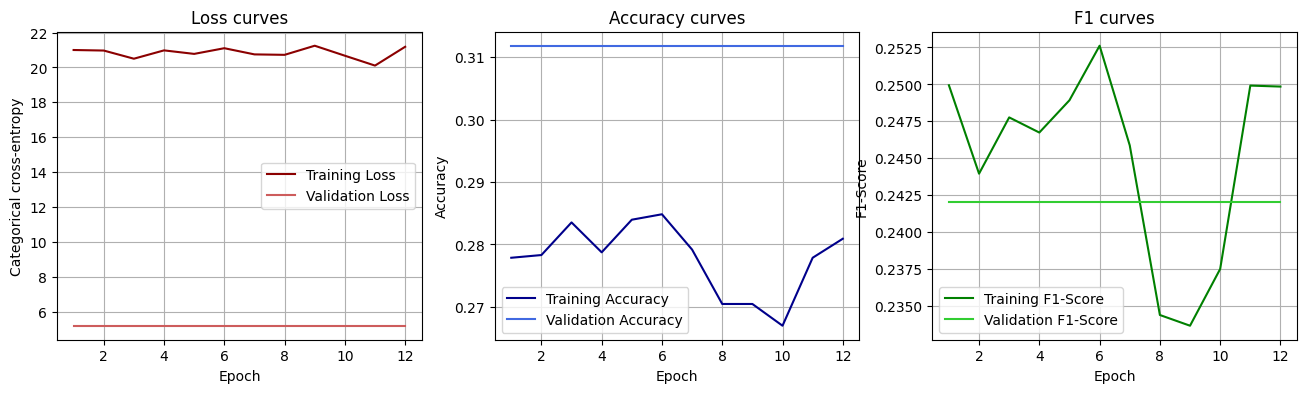

In [ ]:
plot_results(vgg19_train)

### **Prediction**

In [ ]:
model2.evaluate(ds_test)

7/7 [==============================] - 2s 137ms/step - loss: 1.7523 - accuracy: 0.7462 - F1-Score: 0.7037


[1.7523484230041504, 0.7461928725242615, 0.7036975622177124]

In [ ]:
# Make predictions on the test set
y_pred = model2.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 2s 157ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.23      0.05      0.08       100
meningioma_tumor       0.32      0.44      0.37       115
        no_tumor       0.30      0.40      0.34       105
 pituitary_tumor       0.24      0.23      0.23        74

        accuracy                           0.29       394
       macro avg       0.27      0.28      0.26       394
    weighted avg       0.28      0.29      0.26       394



## **ResNet50**

### **Inference**

In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

94765736/94765736 [==============================] - 6s 0us/step


In [ ]:
resnet.trainable = False

In [ ]:
model3 = resnet.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
model3 = tf.keras.layers.Dense(4,activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=resnet.input, outputs = model3)

In [ ]:
# Freeze the weights for all layers
for layer in model3.layers: layer.trainable = False

In [ ]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
model3.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
resnet_train = model3.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 12s 214ms/step - loss: 5.5685 - accuracy: 0.2748 - F1-Score: 0.2256 - val_loss: 2.3392 - val_accuracy: 0.2753 - val_F1-Score: 0.1799
Epoch 2/12
36/36 [==============================] - 7s 185ms/step - loss: 5.5775 - accuracy: 0.2709 - F1-Score: 0.2190 - val_loss: 2.3392 - val_accuracy: 0.2753 - val_F1-Score: 0.1799
Epoch 3/12
36/36 [==============================] - 5s 129ms/step - loss: 5.5063 - accuracy: 0.2805 - F1-Score: 0.2259 - val_loss: 2.3392 - val_accuracy: 0.2753 - val_F1-Score: 0.1799
Epoch 4/12
36/36 [==============================] - 6s 130ms/step - loss: 5.5481 - accuracy: 0.2666 - F1-Score: 0.2125 - val_loss: 2.3392 - val_accuracy: 0.2753 - val_F1-Score: 0.1799
Epoch 5/12
36/36 [==============================] - 6s 159ms/step - loss: 5.6698 - accuracy: 0.2661 - F1-Score: 0.2093 - val_loss: 2.3392 - val_accuracy: 0.2753 - val_F1-Score: 0.1799
Epoch 6/12
36/36 [==============================] - 5s 126ms/step - loss: 5.665

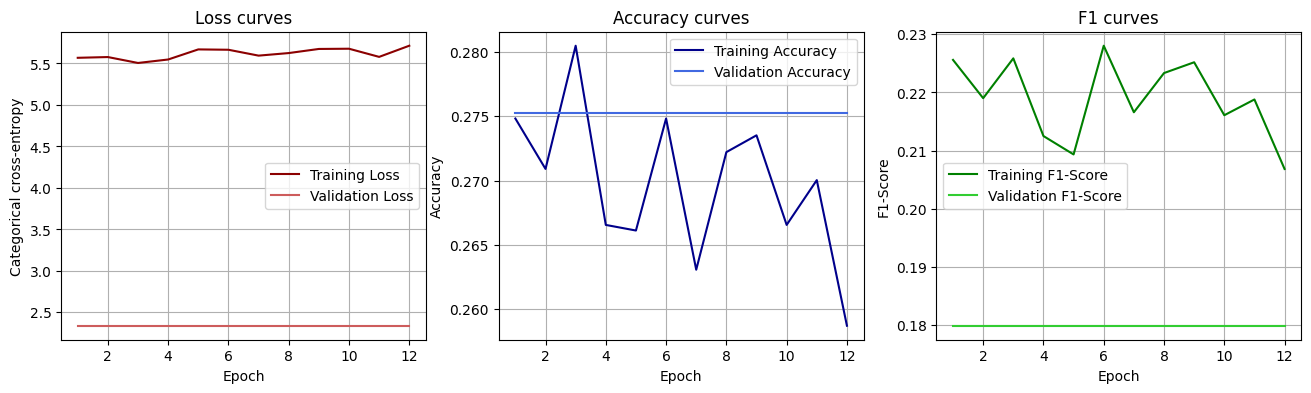

In [ ]:
plot_results(resnet_train)

### **Training** 

In [ ]:
resnet.trainable = True

In [ ]:
model3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
resnet_train1 = model3.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 58s 452ms/step - loss: 2.8068 - accuracy: 0.4717 - F1-Score: 0.4306 - val_loss: 1.9320 - val_accuracy: 0.3571 - val_F1-Score: 0.2700
Epoch 2/12
36/36 [==============================] - 14s 375ms/step - loss: 1.4778 - accuracy: 0.7112 - F1-Score: 0.6827 - val_loss: 1.5790 - val_accuracy: 0.4408 - val_F1-Score: 0.3819
Epoch 3/12
36/36 [==============================] - 14s 367ms/step - loss: 1.0073 - accuracy: 0.8071 - F1-Score: 0.7979 - val_loss: 1.3745 - val_accuracy: 0.4983 - val_F1-Score: 0.4539
Epoch 4/12
36/36 [==============================] - 14s 366ms/step - loss: 0.7284 - accuracy: 0.8685 - F1-Score: 0.8603 - val_loss: 1.1259 - val_accuracy: 0.5592 - val_F1-Score: 0.5326
Epoch 5/12
36/36 [==============================] - 14s 358ms/step - loss: 0.5143 - accuracy: 0.9151 - F1-Score: 0.9100 - val_loss: 0.9449 - val_accuracy: 0.6341 - val_F1-Score: 0.6244
Epoch 6/12
36/36 [==============================] - 14s 364ms/step - loss: 

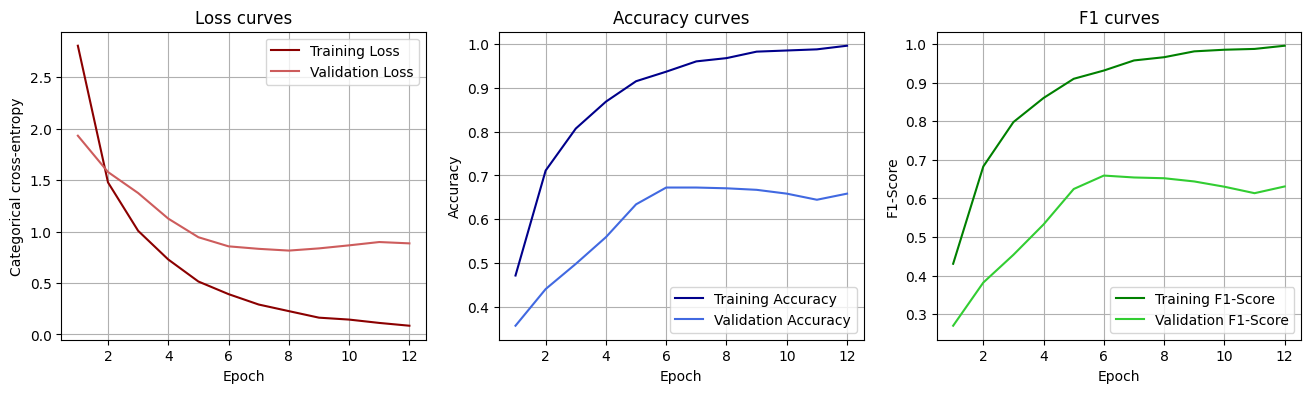

In [ ]:
plot_results(resnet_train1)

### **Prediction**

In [ ]:
model3.evaluate(ds_test)

7/7 [==============================] - 2s 165ms/step - loss: 2.5067 - accuracy: 0.4010 - F1-Score: 0.3055


[2.506685733795166, 0.4010152220726013, 0.30554071068763733]

In [ ]:
# Make predictions on the test set
y_pred = model3.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 2s 92ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.30      0.06      0.10       100
meningioma_tumor       0.28      0.14      0.18       115
        no_tumor       0.26      0.79      0.39       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.27       394
       macro avg       0.21      0.25      0.17       394
    weighted avg       0.23      0.27      0.18       394



## **ResNet101**

### **Inference**

In [ ]:
resnet_101 = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

171446536/171446536 [==============================] - 9s 0us/step


In [ ]:
resnet_101.trainable = False

In [ ]:
model4 = resnet_101.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dropout(rate=0.5)(model4)
model4 = tf.keras.layers.Dense(4,activation='softmax')(model4)
model4 = tf.keras.models.Model(inputs=resnet_101.input, outputs = model4)

In [ ]:
# Freeze the weights for all layers
for layer in model4.layers: layer.trainable = False

In [ ]:
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [ ]:
model4.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
resnet_101_train = model4.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 15s 266ms/step - loss: 5.4029 - accuracy: 0.2805 - F1-Score: 0.2343 - val_loss: 1.9118 - val_accuracy: 0.2787 - val_F1-Score: 0.2222
Epoch 2/12
36/36 [==============================] - 8s 217ms/step - loss: 5.4503 - accuracy: 0.2770 - F1-Score: 0.2338 - val_loss: 1.9118 - val_accuracy: 0.2787 - val_F1-Score: 0.2222
Epoch 3/12
36/36 [==============================] - 9s 245ms/step - loss: 5.3909 - accuracy: 0.2718 - F1-Score: 0.2304 - val_loss: 1.9118 - val_accuracy: 0.2787 - val_F1-Score: 0.2222
Epoch 4/12
36/36 [==============================] - 9s 218ms/step - loss: 5.6086 - accuracy: 0.2613 - F1-Score: 0.2256 - val_loss: 1.9118 - val_accuracy: 0.2787 - val_F1-Score: 0.2222
Epoch 5/12
36/36 [==============================] - 9s 220ms/step - loss: 5.4442 - accuracy: 0.2870 - F1-Score: 0.2435 - val_loss: 1.9118 - val_accuracy: 0.2787 - val_F1-Score: 0.2222
Epoch 6/12
36/36 [==============================] - 9s 244ms/step - loss: 5.511

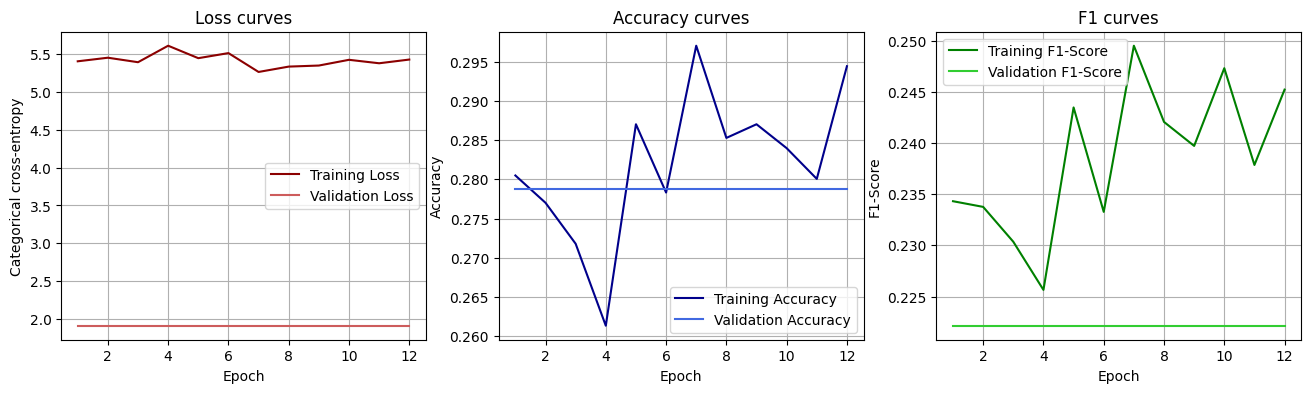

In [ ]:
plot_results(resnet_101_train)

### **Fine Tunning** 

In [ ]:
resnet_101.trainable = True

In [ ]:
model4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.0001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
resnet_101_train1 = model4.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 104s 666ms/step - loss: 1.2310 - accuracy: 0.7731 - F1-Score: 0.7624 - val_loss: 0.9129 - val_accuracy: 0.7648 - val_F1-Score: 0.7261
Epoch 2/12
36/36 [==============================] - 23s 621ms/step - loss: 0.2042 - accuracy: 0.9717 - F1-Score: 0.9723 - val_loss: 0.3733 - val_accuracy: 0.8780 - val_F1-Score: 0.8679
Epoch 3/12
36/36 [==============================] - 23s 606ms/step - loss: 0.0553 - accuracy: 0.9895 - F1-Score: 0.9898 - val_loss: 0.3774 - val_accuracy: 0.8798 - val_F1-Score: 0.8803
Epoch 4/12
36/36 [==============================] - 23s 625ms/step - loss: 0.0346 - accuracy: 0.9956 - F1-Score: 0.9958 - val_loss: 0.4310 - val_accuracy: 0.8484 - val_F1-Score: 0.8526
Epoch 5/12
36/36 [==============================] - 24s 644ms/step - loss: 0.0146 - accuracy: 0.9983 - F1-Score: 0.9981 - val_loss: 0.5269 - val_accuracy: 0.8380 - val_F1-Score: 0.8400
Epoch 6/12
36/36 [==============================] - 22s 609ms/step - loss:

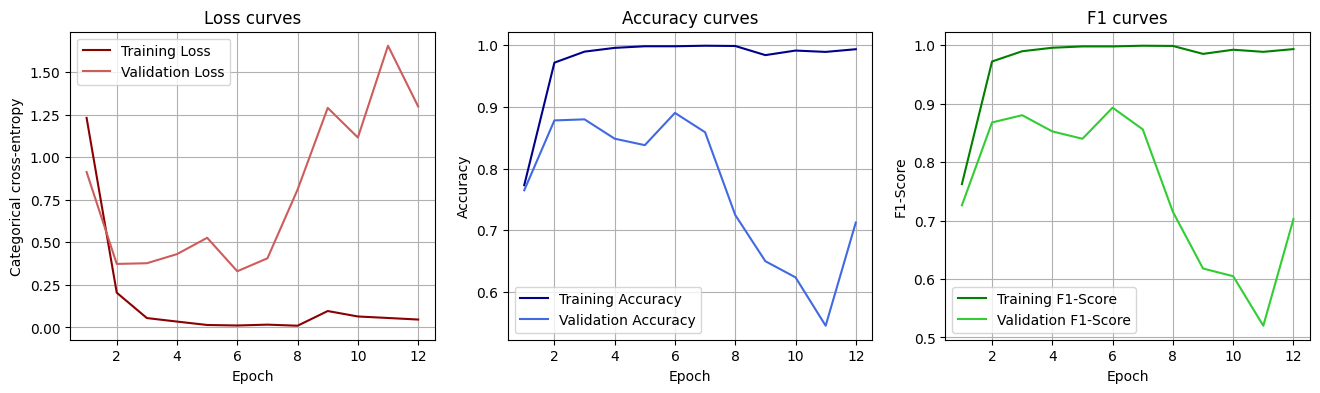

In [ ]:
plot_results(resnet_101_train1)

### **Prediction**

In [ ]:
model4.evaluate(ds_test)

7/7 [==============================] - 2s 144ms/step - loss: 3.8599 - accuracy: 0.5431 - F1-Score: 0.4569


[3.8599140644073486, 0.5431472063064575, 0.45690155029296875]

In [ ]:
# Make predictions on the test set
y_pred = model4.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 3s 165ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.06      0.01      0.02       100
meningioma_tumor       0.28      0.43      0.34       115
        no_tumor       0.28      0.51      0.36       105
 pituitary_tumor       0.25      0.04      0.07        74

        accuracy                           0.27       394
       macro avg       0.22      0.25      0.20       394
    weighted avg       0.22      0.27      0.21       394



## **InceptionV3**

### **Inference**

In [ ]:
inc = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
inc.trainable = False

In [ ]:
model5 = inc.output
model5 = tf.keras.layers.GlobalAveragePooling2D()(model5)
model5 = tf.keras.layers.Dropout(rate=0.5)(model5)
model5 = tf.keras.layers.Dense(4,activation='softmax')(model5)
model5 = tf.keras.models.Model(inputs=inc.input, outputs = model5)

In [ ]:
# Freeze the weights for all layers
for layer in model5.layers: layer.trainable = False

In [ ]:
model5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                            

In [ ]:
model5.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
inc_train = model5.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 14s 215ms/step - loss: 79.6885 - accuracy: 0.2409 - F1-Score: 0.1997 - val_loss: 22.1208 - val_accuracy: 0.2892 - val_F1-Score: 0.1804
Epoch 2/12
36/36 [==============================] - 6s 151ms/step - loss: 76.4631 - accuracy: 0.2574 - F1-Score: 0.2182 - val_loss: 22.1208 - val_accuracy: 0.2892 - val_F1-Score: 0.1804
Epoch 3/12
36/36 [==============================] - 4s 100ms/step - loss: 76.0222 - accuracy: 0.2361 - F1-Score: 0.2014 - val_loss: 22.1208 - val_accuracy: 0.2892 - val_F1-Score: 0.1804
Epoch 4/12
36/36 [==============================] - 6s 144ms/step - loss: 78.2043 - accuracy: 0.2317 - F1-Score: 0.1936 - val_loss: 22.1208 - val_accuracy: 0.2892 - val_F1-Score: 0.1804
Epoch 5/12
36/36 [==============================] - 4s 102ms/step - loss: 80.0831 - accuracy: 0.2365 - F1-Score: 0.1947 - val_loss: 22.1208 - val_accuracy: 0.2892 - val_F1-Score: 0.1804
Epoch 6/12
36/36 [==============================] - 4s 104ms/step - l

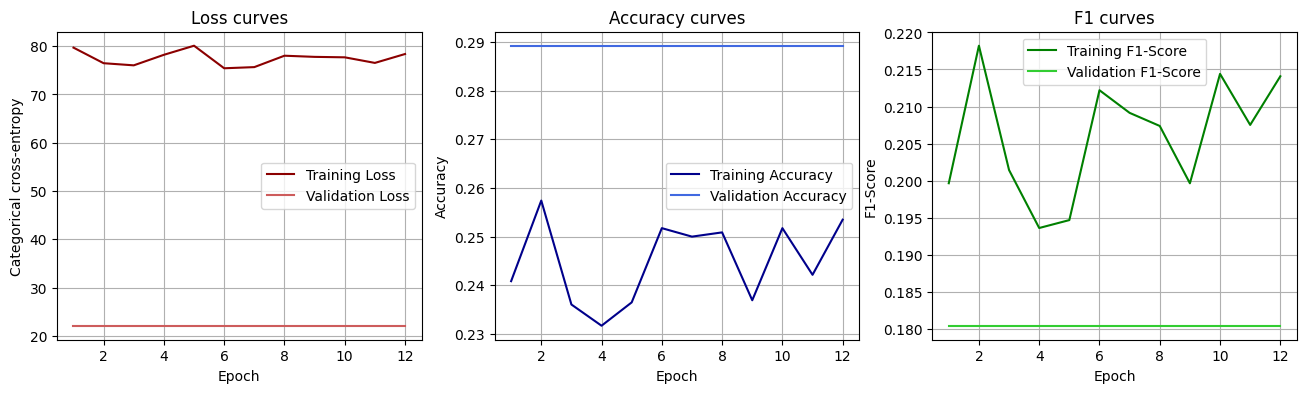

In [ ]:
plot_results(inc_train)

### **Training** 

In [ ]:
inc.trainable = True

In [ ]:
model5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
inc_train1 = model5.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 60s 414ms/step - loss: 3.6035 - accuracy: 0.2927 - F1-Score: 0.2821 - val_loss: 1.7177 - val_accuracy: 0.3345 - val_F1-Score: 0.2975
Epoch 2/12
36/36 [==============================] - 11s 281ms/step - loss: 2.4105 - accuracy: 0.5605 - F1-Score: 0.5337 - val_loss: 1.2116 - val_accuracy: 0.5052 - val_F1-Score: 0.4789
Epoch 3/12
36/36 [==============================] - 11s 275ms/step - loss: 1.7820 - accuracy: 0.6803 - F1-Score: 0.6494 - val_loss: 0.9602 - val_accuracy: 0.6220 - val_F1-Score: 0.5979
Epoch 4/12
36/36 [==============================] - 9s 229ms/step - loss: 1.3723 - accuracy: 0.7430 - F1-Score: 0.7181 - val_loss: 0.7862 - val_accuracy: 0.7038 - val_F1-Score: 0.6856
Epoch 5/12
36/36 [==============================] - 9s 226ms/step - loss: 1.1293 - accuracy: 0.7879 - F1-Score: 0.7752 - val_loss: 0.6710 - val_accuracy: 0.7300 - val_F1-Score: 0.7214
Epoch 6/12
36/36 [==============================] - 8s 218ms/step - loss: 0.8

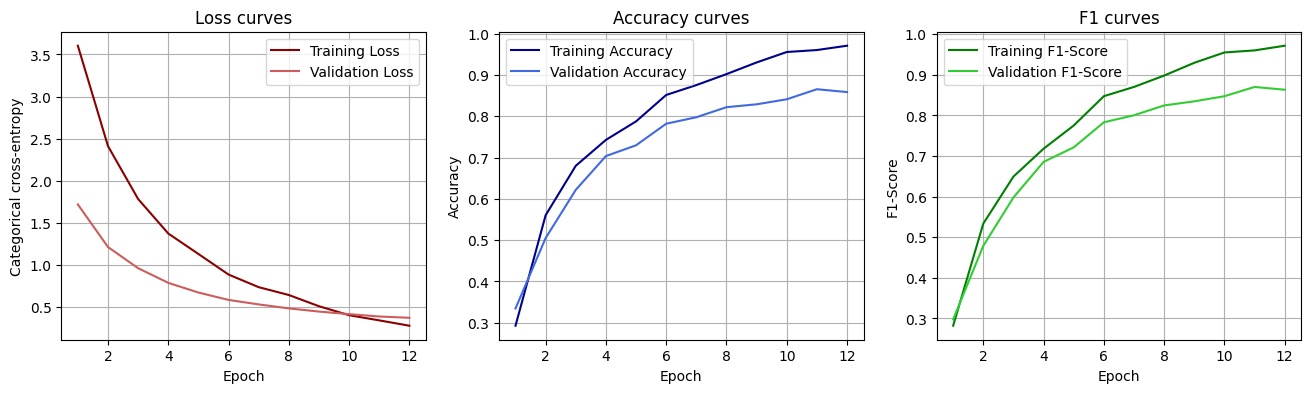

In [ ]:
plot_results(inc_train1)

### **Prediction**

In [ ]:
model5.evaluate(ds_test)

7/7 [==============================] - 3s 279ms/step - loss: 1.0985 - accuracy: 0.7462 - F1-Score: 0.6995


[1.0985114574432373, 0.7461928725242615, 0.6994569301605225]

In [ ]:
# Make predictions on the test set
y_pred = model5.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 4s 62ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.21      0.05      0.08       100
meningioma_tumor       0.28      0.33      0.30       115
        no_tumor       0.27      0.39      0.32       105
 pituitary_tumor       0.18      0.20      0.19        74

        accuracy                           0.25       394
       macro avg       0.24      0.24      0.22       394
    weighted avg       0.24      0.25      0.23       394



## **InceptionResNetV2**

### **Inference**

In [ ]:
inc_res = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
inc_res.trainable = False

In [ ]:
model6 = inc_res.output
model6 = tf.keras.layers.GlobalAveragePooling2D()(model6)
model6 = tf.keras.layers.Dropout(rate=0.5)(model6)
model6 = tf.keras.layers.Dense(4,activation='softmax')(model6)
model6 = tf.keras.models.Model(inputs=inc_res.input, outputs = model6)

In [ ]:
# Freeze the weights for all layers
for layer in model6.layers: layer.trainable = False

In [ ]:
model6.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_95 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
model6.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
inc_res_train = model6.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 24s 333ms/step - loss: 408.6041 - accuracy: 0.2369 - F1-Score: 0.2159 - val_loss: 80.3187 - val_accuracy: 0.1463 - val_F1-Score: 0.0640
Epoch 2/12
36/36 [==============================] - 7s 167ms/step - loss: 395.6333 - accuracy: 0.2334 - F1-Score: 0.2106 - val_loss: 80.3187 - val_accuracy: 0.1463 - val_F1-Score: 0.0640
Epoch 3/12
36/36 [==============================] - 8s 182ms/step - loss: 424.6040 - accuracy: 0.2226 - F1-Score: 0.2001 - val_loss: 80.3187 - val_accuracy: 0.1463 - val_F1-Score: 0.0640
Epoch 4/12
36/36 [==============================] - 9s 236ms/step - loss: 422.9009 - accuracy: 0.2274 - F1-Score: 0.2012 - val_loss: 80.3187 - val_accuracy: 0.1463 - val_F1-Score: 0.0640
Epoch 5/12
36/36 [==============================] - 7s 171ms/step - loss: 412.5714 - accuracy: 0.2152 - F1-Score: 0.1953 - val_loss: 80.3187 - val_accuracy: 0.1463 - val_F1-Score: 0.0640
Epoch 6/12
36/36 [==============================] - 8s 196ms/ste

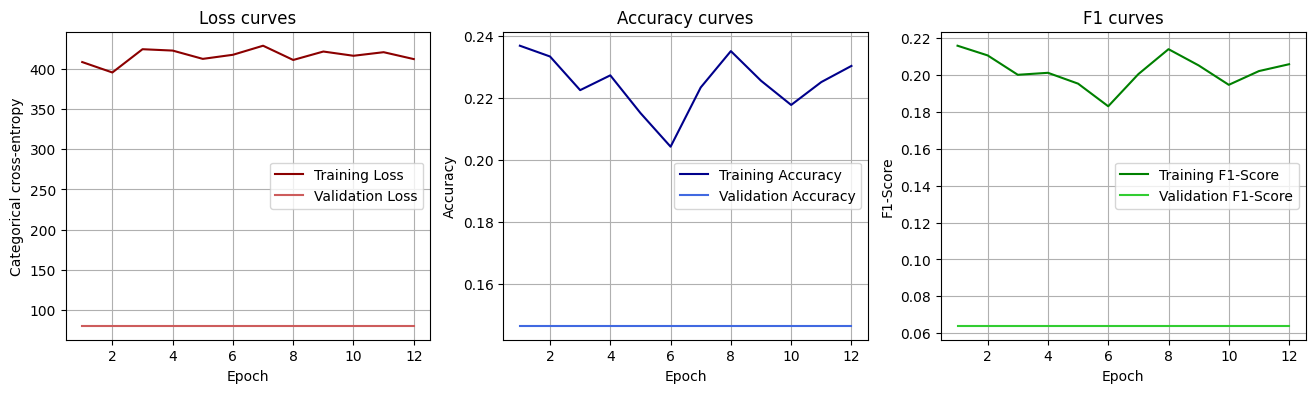

In [ ]:
plot_results(inc_res_train)

### **Training** 

In [ ]:
inc_res.trainable = True

In [ ]:
model6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
inc_res_train1 = model6.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 127s 639ms/step - loss: 2.7964 - accuracy: 0.4438 - F1-Score: 0.4347 - val_loss: 1.5513 - val_accuracy: 0.3415 - val_F1-Score: 0.3165
Epoch 2/12
36/36 [==============================] - 19s 490ms/step - loss: 1.9033 - accuracy: 0.6934 - F1-Score: 0.6808 - val_loss: 1.0186 - val_accuracy: 0.5749 - val_F1-Score: 0.5637
Epoch 3/12
36/36 [==============================] - 18s 487ms/step - loss: 1.3538 - accuracy: 0.8044 - F1-Score: 0.7909 - val_loss: 0.7272 - val_accuracy: 0.7247 - val_F1-Score: 0.7189
Epoch 4/12
36/36 [==============================] - 18s 483ms/step - loss: 1.0038 - accuracy: 0.8650 - F1-Score: 0.8580 - val_loss: 0.5369 - val_accuracy: 0.8171 - val_F1-Score: 0.8102
Epoch 5/12
36/36 [==============================] - 21s 504ms/step - loss: 0.7455 - accuracy: 0.8985 - F1-Score: 0.8911 - val_loss: 0.4320 - val_accuracy: 0.8519 - val_F1-Score: 0.8459
Epoch 6/12
36/36 [==============================] - 21s 563ms/step - loss:

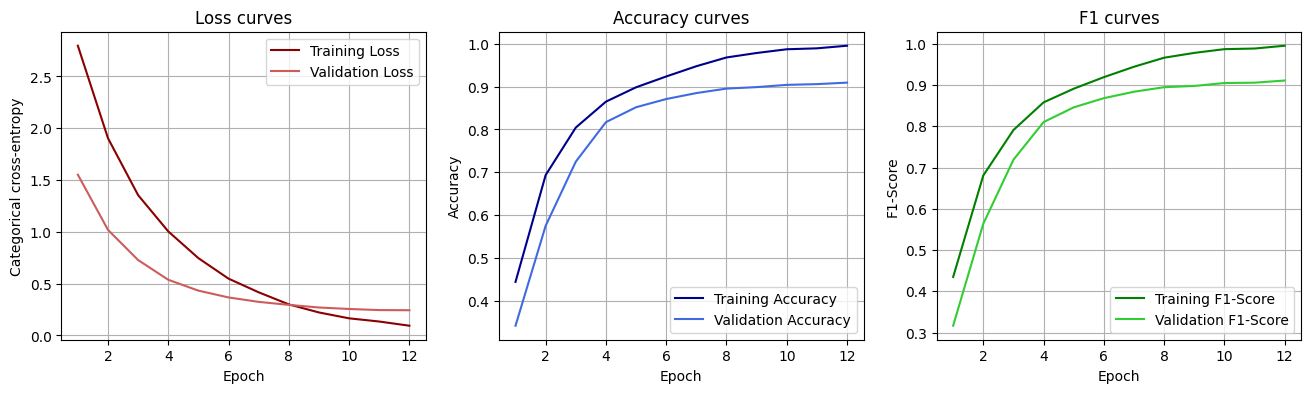

In [ ]:
plot_results(inc_res_train1)

### **Prediction**

In [ ]:
model6.evaluate(ds_test)

7/7 [==============================] - 3s 252ms/step - loss: 1.2884 - accuracy: 0.7107 - F1-Score: 0.6683


[1.2883933782577515, 0.710659921169281, 0.6682840585708618]

In [ ]:
# Make predictions on the test set
y_pred = model6.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 5s 131ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.33      0.09      0.14       100
meningioma_tumor       0.29      0.39      0.33       115
        no_tumor       0.26      0.38      0.31       105
 pituitary_tumor       0.23      0.18      0.20        74

        accuracy                           0.27       394
       macro avg       0.28      0.26      0.25       394
    weighted avg       0.28      0.27      0.25       394



## **DenseNet121**

### **Inference**

In [ ]:
dense_121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
dense_121.trainable = False

In [ ]:
model7 = dense_121.output
model7 = tf.keras.layers.GlobalAveragePooling2D()(model7)
model7 = tf.keras.layers.Dropout(rate=0.5)(model7)
model7 = tf.keras.layers.Dense(4,activation='softmax')(model7)
model7 = tf.keras.models.Model(inputs=dense_121.input, outputs = model7)

In [ ]:
# Freeze the weights for all layers
for layer in model7.layers: layer.trainable = False

In [ ]:
model7.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_8[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']       

In [ ]:
model7.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
dense_121_train = model7.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 19s 297ms/step - loss: 14.5287 - accuracy: 0.2787 - F1-Score: 0.2549 - val_loss: 3.8436 - val_accuracy: 0.2474 - val_F1-Score: 0.1986
Epoch 2/12
36/36 [==============================] - 5s 120ms/step - loss: 15.0305 - accuracy: 0.2674 - F1-Score: 0.2398 - val_loss: 3.8436 - val_accuracy: 0.2474 - val_F1-Score: 0.1986
Epoch 3/12
36/36 [==============================] - 5s 121ms/step - loss: 14.7195 - accuracy: 0.2713 - F1-Score: 0.2463 - val_loss: 3.8436 - val_accuracy: 0.2474 - val_F1-Score: 0.1986
Epoch 4/12
36/36 [==============================] - 7s 162ms/step - loss: 14.6954 - accuracy: 0.2705 - F1-Score: 0.2474 - val_loss: 3.8436 - val_accuracy: 0.2474 - val_F1-Score: 0.1986
Epoch 5/12
36/36 [==============================] - 5s 122ms/step - loss: 14.8374 - accuracy: 0.2809 - F1-Score: 0.2469 - val_loss: 3.8436 - val_accuracy: 0.2474 - val_F1-Score: 0.1986
Epoch 6/12
36/36 [==============================] - 6s 144ms/step - loss: 

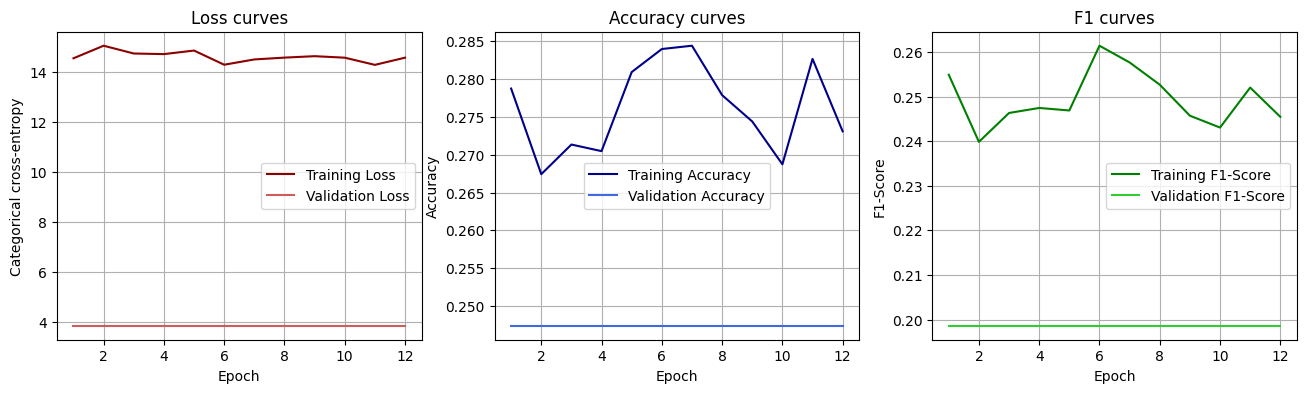

In [ ]:
plot_results(dense_121_train)

### **Training** 

In [ ]:
dense_121.trainable = True

In [ ]:
model7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
dense_121_train1 = model7.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 100s 560ms/step - loss: 4.0621 - accuracy: 0.3589 - F1-Score: 0.3400 - val_loss: 1.4131 - val_accuracy: 0.4495 - val_F1-Score: 0.3910
Epoch 2/12
36/36 [==============================] - 15s 400ms/step - loss: 2.3928 - accuracy: 0.5566 - F1-Score: 0.5328 - val_loss: 0.8955 - val_accuracy: 0.6516 - val_F1-Score: 0.6401
Epoch 3/12
36/36 [==============================] - 14s 373ms/step - loss: 1.8469 - accuracy: 0.6559 - F1-Score: 0.6344 - val_loss: 0.6497 - val_accuracy: 0.7439 - val_F1-Score: 0.7391
Epoch 4/12
36/36 [==============================] - 15s 406ms/step - loss: 1.3410 - accuracy: 0.7400 - F1-Score: 0.7236 - val_loss: 0.5268 - val_accuracy: 0.8049 - val_F1-Score: 0.8027
Epoch 5/12
36/36 [==============================] - 15s 404ms/step - loss: 1.1783 - accuracy: 0.7827 - F1-Score: 0.7697 - val_loss: 0.4594 - val_accuracy: 0.8293 - val_F1-Score: 0.8290
Epoch 6/12
36/36 [==============================] - 15s 395ms/step - loss:

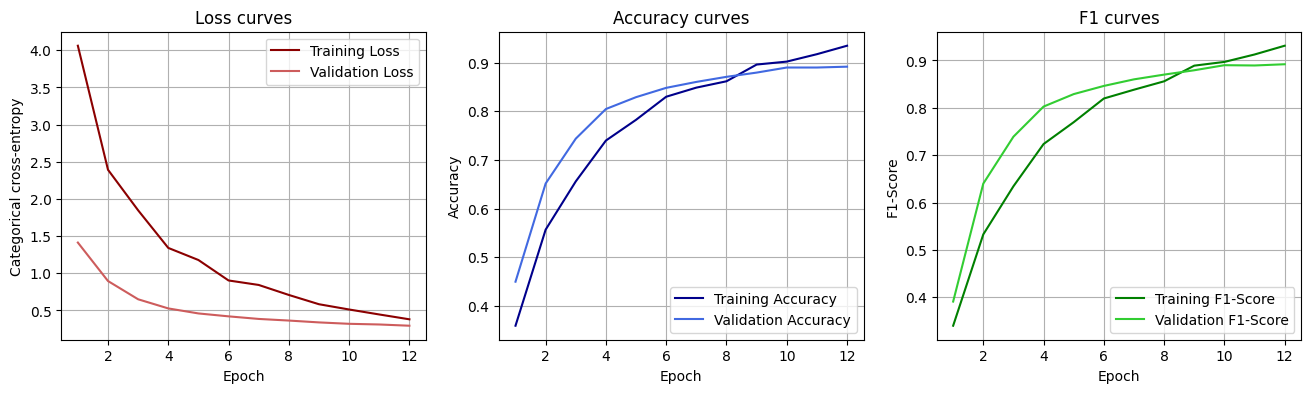

In [ ]:
plot_results(dense_121_train1)

### **Prediction**

In [ ]:
model7.evaluate(ds_test)

7/7 [==============================] - 3s 327ms/step - loss: 1.2984 - accuracy: 0.7005 - F1-Score: 0.6681


[1.2983952760696411, 0.700507640838623, 0.6681097745895386]

In [ ]:
# Make predictions on the test set
y_pred = model7.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 4s 101ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.21      0.04      0.07       100
meningioma_tumor       0.28      0.31      0.29       115
        no_tumor       0.31      0.54      0.40       105
 pituitary_tumor       0.24      0.20      0.22        74

        accuracy                           0.28       394
       macro avg       0.26      0.27      0.24       394
    weighted avg       0.26      0.28      0.25       394



## **Xception**

### **Inference**

In [ ]:
xception = Xception(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
xception.trainable = False

In [ ]:
model8 = xception.output
model8 = tf.keras.layers.GlobalAveragePooling2D()(model8)
model8 = tf.keras.layers.Dropout(rate=0.5)(model8)
model8 = tf.keras.layers.Dense(4,activation='softmax')(model8)
model8 = tf.keras.models.Model(inputs=xception.input, outputs = model8)

In [ ]:
# Freeze the weights for all layers
for layer in model8.layers: layer.trainable = False

In [ ]:
model8.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_9[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [ ]:
model8.compile(loss='categorical_crossentropy',optimizer = 'Adam', 
metrics=[metrics.CategoricalAccuracy(name='accuracy'), tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')])

In [ ]:
xception_train = model8.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 16s 275ms/step - loss: 25.4593 - accuracy: 0.1838 - F1-Score: 0.1719 - val_loss: 7.0446 - val_accuracy: 0.1341 - val_F1-Score: 0.1135
Epoch 2/12
36/36 [==============================] - 8s 195ms/step - loss: 25.0008 - accuracy: 0.1877 - F1-Score: 0.1766 - val_loss: 7.0446 - val_accuracy: 0.1341 - val_F1-Score: 0.1135
Epoch 3/12
36/36 [==============================] - 6s 154ms/step - loss: 24.8879 - accuracy: 0.1903 - F1-Score: 0.1819 - val_loss: 7.0446 - val_accuracy: 0.1341 - val_F1-Score: 0.1135
Epoch 4/12
36/36 [==============================] - 9s 210ms/step - loss: 25.1987 - accuracy: 0.1908 - F1-Score: 0.1797 - val_loss: 7.0446 - val_accuracy: 0.1341 - val_F1-Score: 0.1135
Epoch 5/12
36/36 [==============================] - 7s 170ms/step - loss: 25.3250 - accuracy: 0.1855 - F1-Score: 0.1759 - val_loss: 7.0446 - val_accuracy: 0.1341 - val_F1-Score: 0.1135
Epoch 6/12
36/36 [==============================] - 7s 159ms/step - loss: 

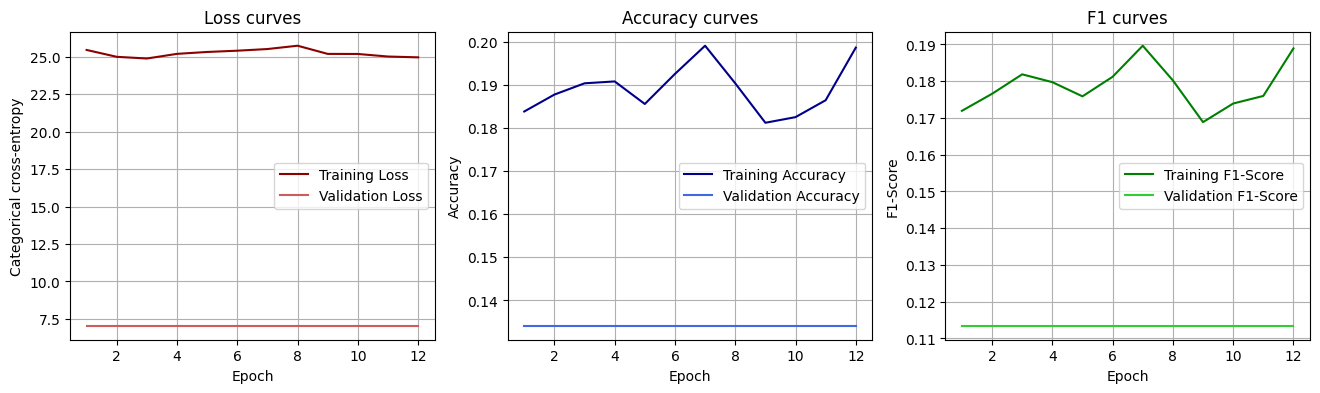

In [ ]:
plot_results(xception_train)

### **Training** 

In [ ]:
xception.trainable = True

In [ ]:
model8.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=0.00001 ),
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      tfa.metrics.F1Score(num_classes=4, average='macro', name='F1-Score')
                      ])

In [ ]:
xception_train1 = model8.fit(ds_train, epochs=12, validation_data=ds_val, class_weight = class_weights)

Epoch 1/12
36/36 [==============================] - 58s 642ms/step - loss: 3.3540 - accuracy: 0.3105 - F1-Score: 0.2598 - val_loss: 1.4908 - val_accuracy: 0.2753 - val_F1-Score: 0.1828
Epoch 2/12
36/36 [==============================] - 18s 469ms/step - loss: 2.8483 - accuracy: 0.4639 - F1-Score: 0.4362 - val_loss: 1.2328 - val_accuracy: 0.4164 - val_F1-Score: 0.3768
Epoch 3/12
36/36 [==============================] - 18s 483ms/step - loss: 2.4999 - accuracy: 0.6346 - F1-Score: 0.6224 - val_loss: 1.0546 - val_accuracy: 0.5749 - val_F1-Score: 0.5634
Epoch 4/12
36/36 [==============================] - 18s 478ms/step - loss: 2.1412 - accuracy: 0.7361 - F1-Score: 0.7264 - val_loss: 0.8961 - val_accuracy: 0.7334 - val_F1-Score: 0.7354
Epoch 5/12
36/36 [==============================] - 17s 465ms/step - loss: 1.7485 - accuracy: 0.7949 - F1-Score: 0.7847 - val_loss: 0.7374 - val_accuracy: 0.7927 - val_F1-Score: 0.7924
Epoch 6/12
36/36 [==============================] - 18s 474ms/step - loss: 

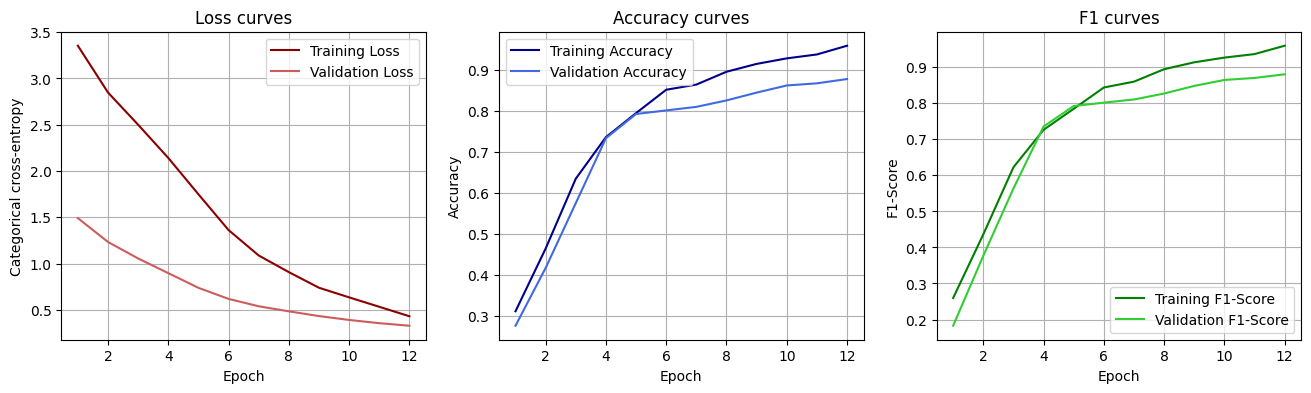

In [ ]:
plot_results(xception_train1)

### **Prediction**

In [ ]:
model8.evaluate(ds_test)

7/7 [==============================] - 2s 163ms/step - loss: 1.1908 - accuracy: 0.6954 - F1-Score: 0.6584


[1.1908273696899414, 0.6954314708709717, 0.6584333181381226]

In [ ]:
# Make predictions on the test set
y_pred = model8.predict(ds_test)

# Get the predicted class for each image
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class for each image
y_true_classes = np.concatenate([y.numpy() for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true_classes, axis=1)

# Print the classification report
target_names = ds_test.class_names
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

7/7 [==============================] - 2s 124ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.23      0.06      0.10       100
meningioma_tumor       0.28      0.45      0.35       115
        no_tumor       0.23      0.30      0.26       105
 pituitary_tumor       0.20      0.12      0.15        74

        accuracy                           0.25       394
       macro avg       0.24      0.23      0.21       394
    weighted avg       0.24      0.25      0.22       394



# **Results Comparison**

* These base models were tested in similar conditions, where the same layers were applied and the models generated were compiled using the same conditions and metrics.
* As already expected, the results obtained revealed to be extremely promising in most cases. The validation F1-Score results showed very positive results, apart from the models ResNet50 and ResNet101 where a large discrepancy between Training and Validation F1-Score results was visible.
We may be in the presence of overfitting, which could have been caused by the lower learning rate, causing the models to converge slowly. A suitable solution could have been an extension of the number of epochs or a decrease in the learning rate.

* Comparing to our best model, CNN_V6_HYPER_5, these models revealed to be superior in generalization and less sensitive to specific data, with steadier F1-Score curves. 
* However, it is also important to highlight the difference between the complexity of the base models applied in this notebook and the CNN_V6_HYPER_5 model. One could argue that, attending the tradeoff between results and computational effort, the CNN_V6_HYPER_5 achieves results above expected.

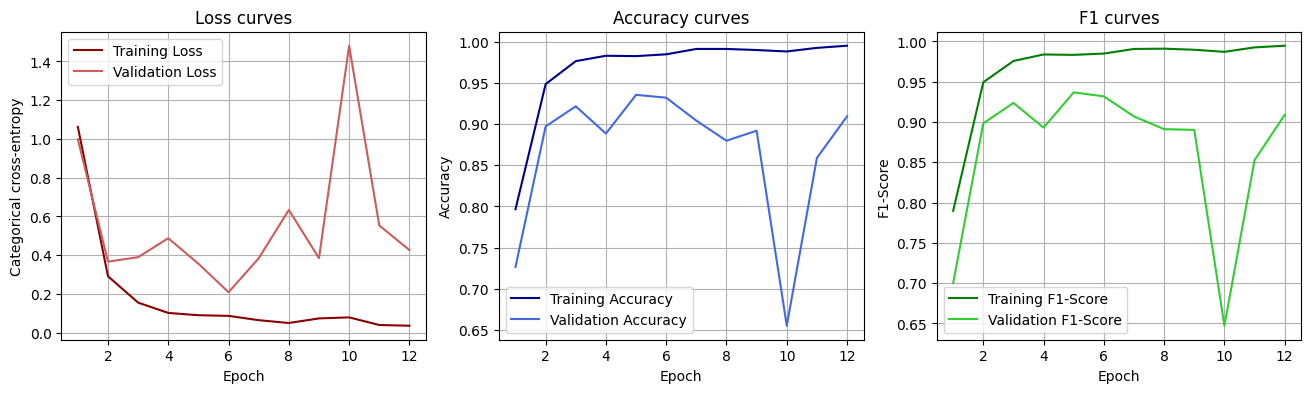

In [ ]:
plot_results(eff_train1)

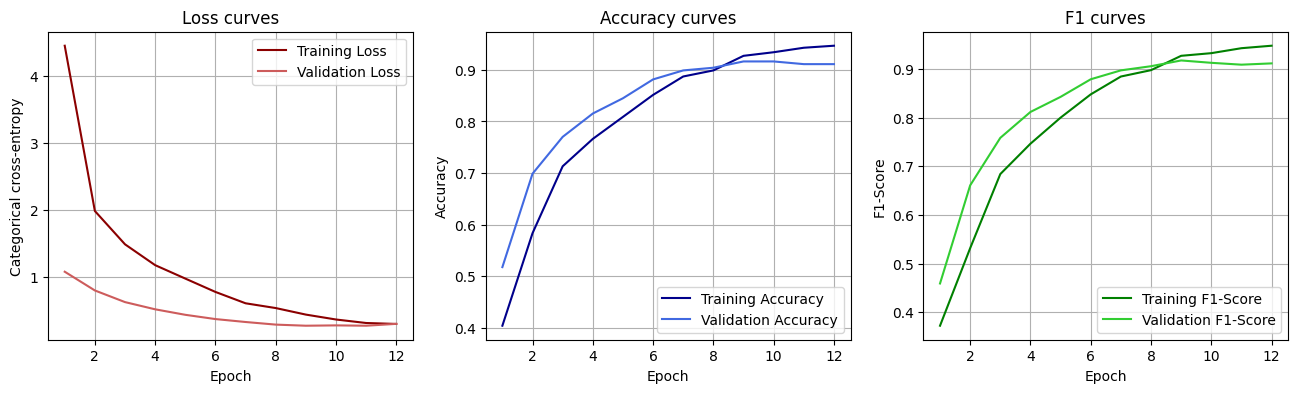

In [ ]:
plot_results(vgg16_train1)

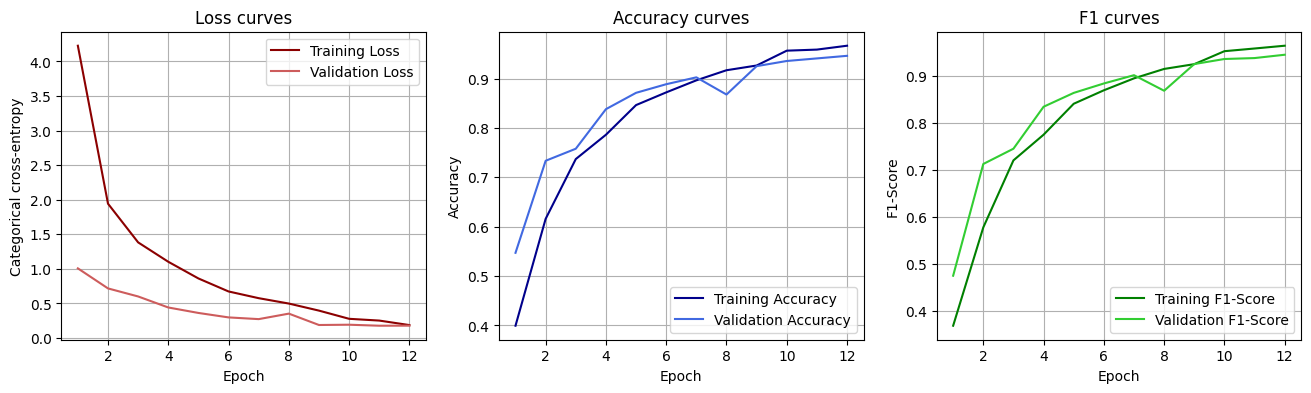

In [ ]:
plot_results(vgg19_train1)

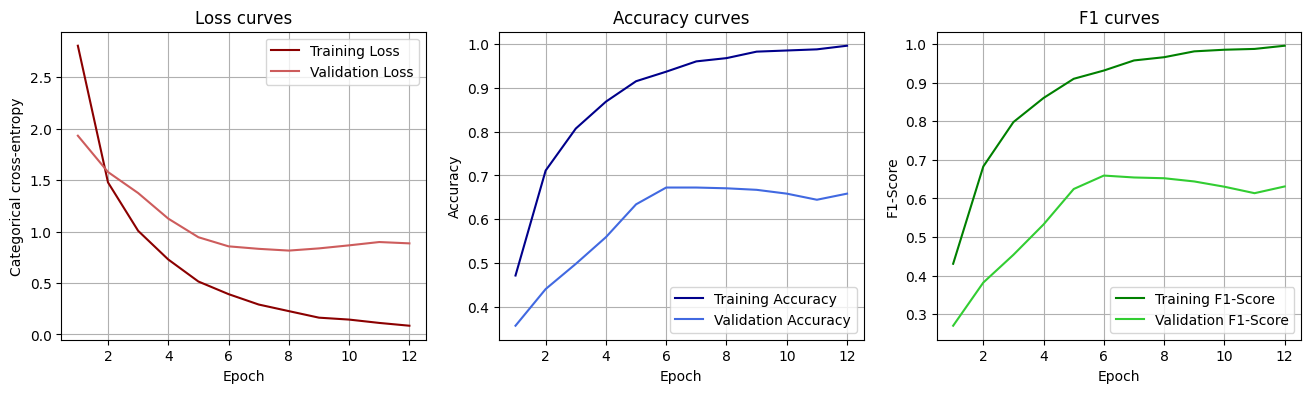

In [ ]:
plot_results(resnet_train1)

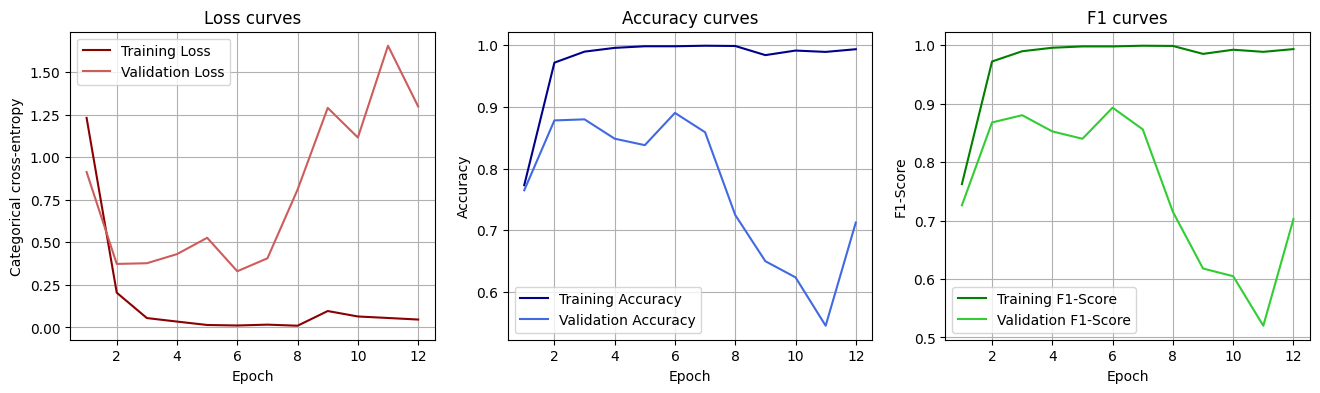

In [ ]:
plot_results(resnet_101_train1)

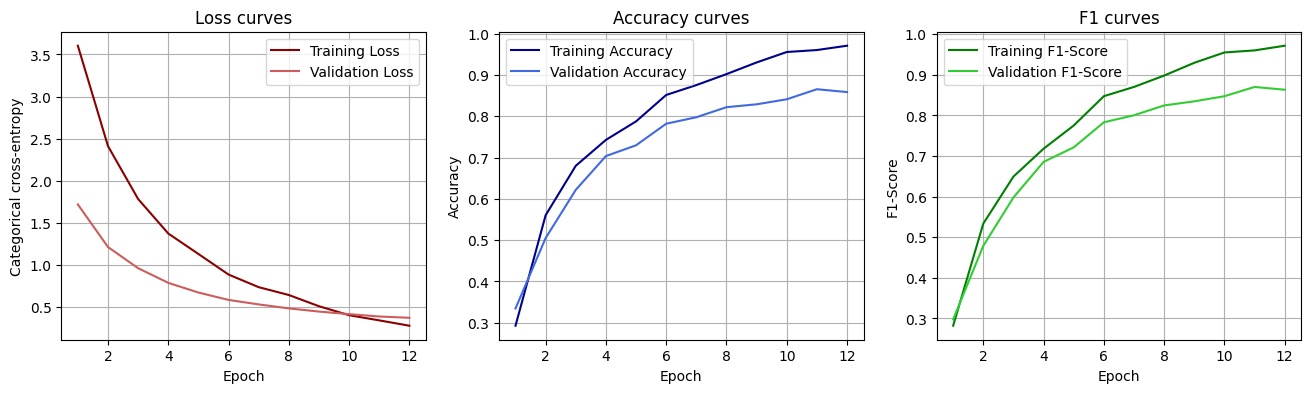

In [ ]:
plot_results(inc_train1)

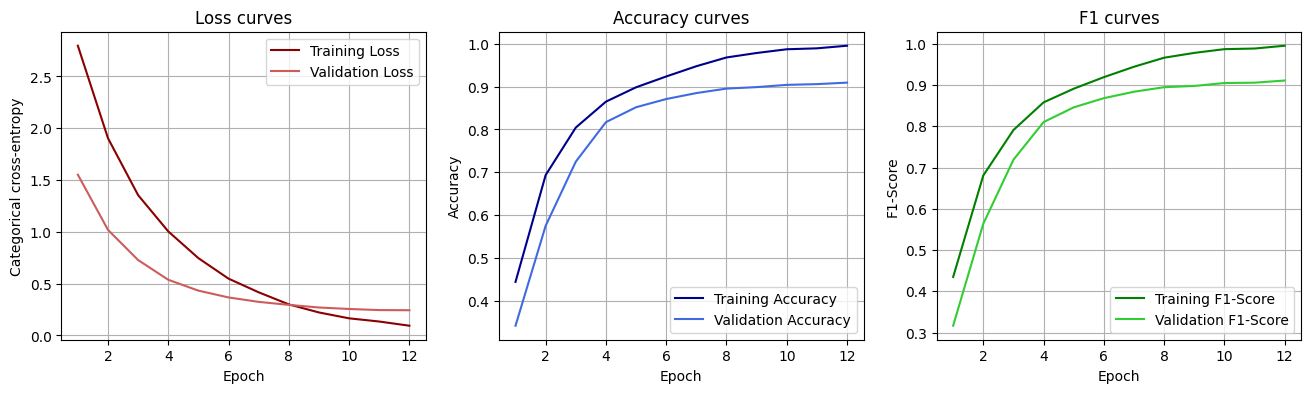

In [ ]:
plot_results(inc_res_train1)

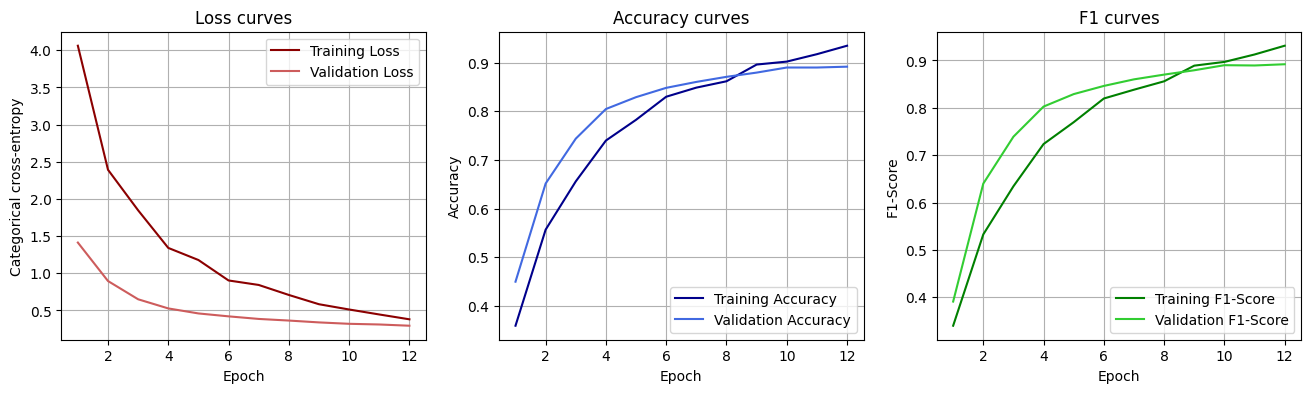

In [ ]:
plot_results(dense_121_train1)

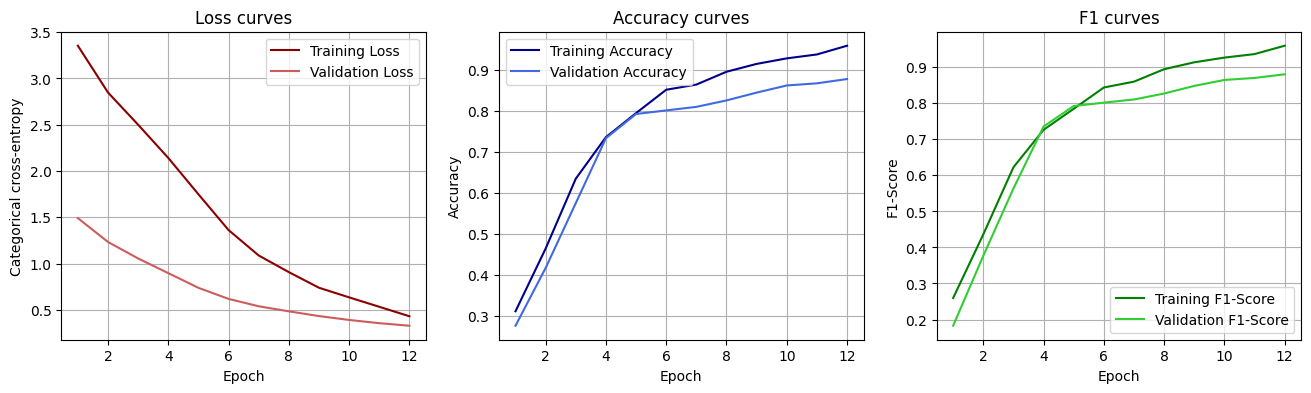

In [ ]:
plot_results(xception_train1)